In [1]:
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
mpl.rcParams["image.cmap"] = "Blues"
mpl.rcParams["figure.dpi"] = 100

import h5py
import os
import numpy as np
from glob import glob

import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
inputdir_ele = "/work/dvalsecc/Clustering/dataset/electrons_awkward_2022v7/"
inputdir_gamma = "/work/dvalsecc/Clustering/dataset/gammas_awkward_2022v7/"

In [3]:
cols = ["cl_features", "cl_labels", "window_features", "window_metadata", "cl_h"]
df_ele = ak.from_parquet(inputdir_ele, lazy=True, use_threads=True, columns=cols)
df_gamma = ak.from_parquet(inputdir_gamma, lazy=True, use_threads=True, columns=cols)

# Dataset studies 

### Number of clusters distrubution

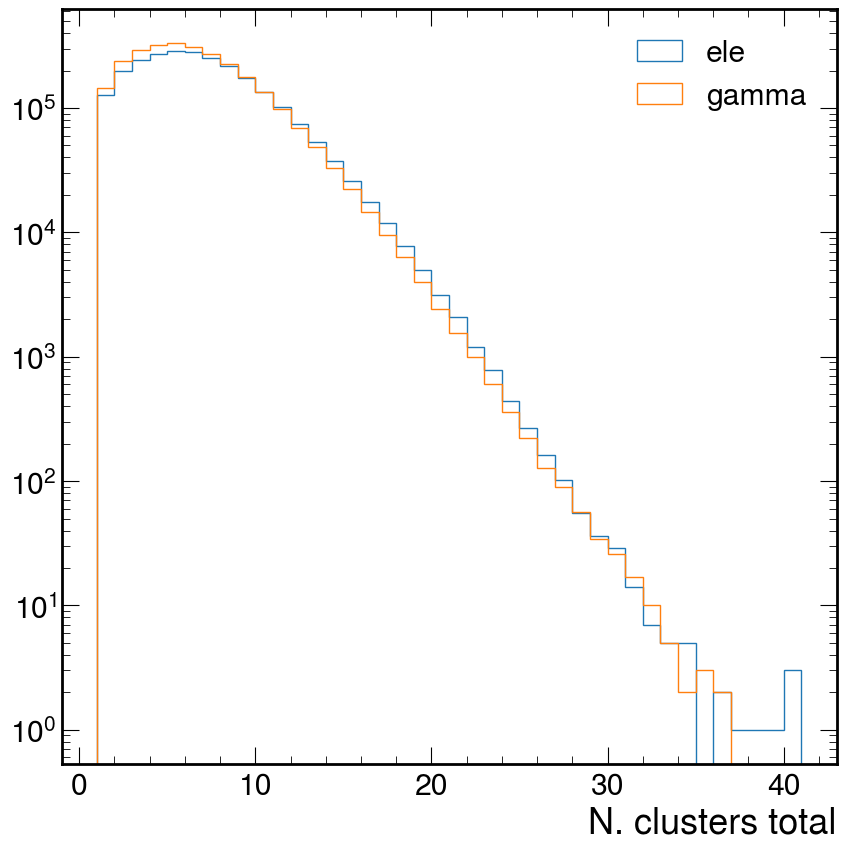

In [16]:
plt.hist(ak.num(df_ele.cl_features, axis=1), bins=40, range=(1, 41), histtype="step", label="ele")
plt.hist(ak.num(df_gamma.cl_features, axis=1), bins=40, range=(1, 41), histtype="step", label="gamma")
plt.yscale("log")
plt.xlabel("N. clusters total")
plt.legend()

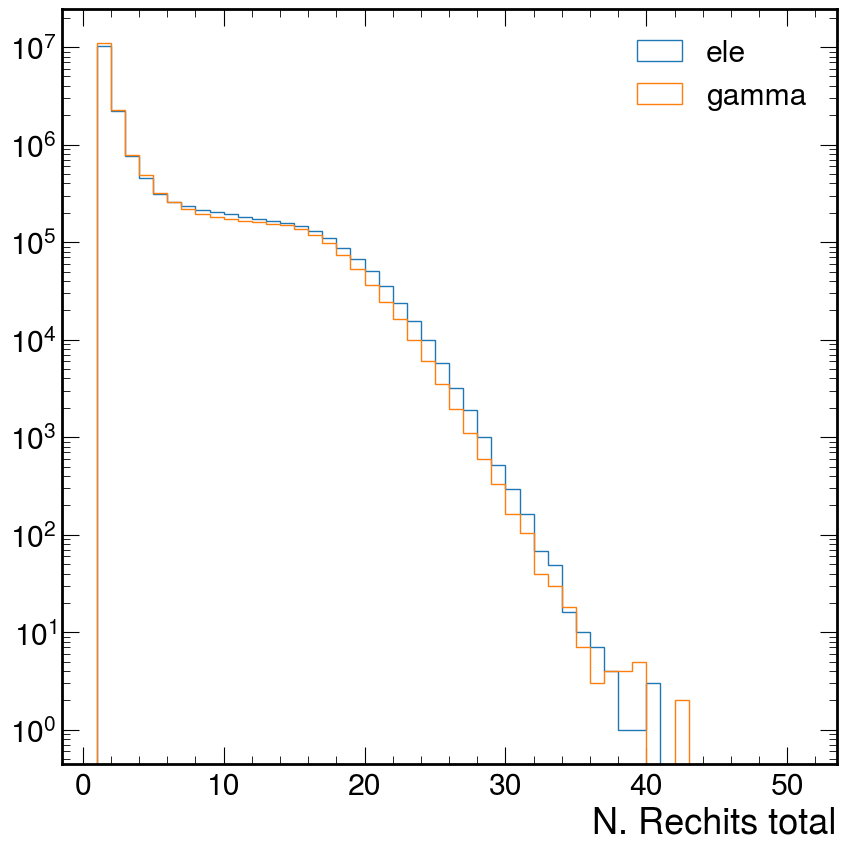

In [17]:
plt.hist(ak.flatten(ak.num(df_ele.cl_h, axis=2)), bins=50, range=(1, 51), histtype="step", label="ele")
plt.hist(ak.flatten(ak.num(df_gamma.cl_h, axis=2)), bins=50, range=(1, 51), histtype="step", label="gamma")
plt.yscale("log")
plt.xlabel("N. Rechits total")
plt.legend()

In [7]:
def plot_window_rechits(df):
    d = 5
    xmin = ak.min(df[:,:,1])-d
    xmax = ak.max(df[:,:,1])+d
    ymin = ak.min(df[:,:,0])-d
    ymax = ak.max(df[:,:,0])+d
    plt.hist2d(ak.flatten(df[:,:,1]), ak.flatten(df[:,:,0]), weights=ak.flatten(df[:,:,3]), range=((xmin, xmax), (ymin, ymax)), bins=(int(xmax-xmin), int(ymax-ymin)), norm=LogNorm(), cmap="viridis")
    plt.ylabel("ieta")
    plt.xlabel("iphi")
    plt.colorbar(label="Rechit Energy [GeV]")
    plt.show()

# Training dataset preparation

In [3]:
from itertools import zip_longest, islice
from collections import deque

def load_dataset_chunks(df, config, chunk_size, maxevents, offset=0):
    # Filtering the columns to keey only the requested ones
    cols = { key: df[key][v] for key, v in config["columns"].items() }
    # Adding the clusters hits 
    if config["read_hits"]:
        cols['cl_h'] = df.cl_h
    filtered_df = ak.zip(cols, depth_limit=1)
    # Now load in large chunks batching
    nchunks = maxevents//chunk_size
    for i in range(nchunks):
        # Then materialize it
        yield chunk_size, ak.materialized(filtered_df[offset + i*chunk_size: offset + (i+1)*chunk_size])
        #yield batch_size, df[i*batch_size: (i+1)*batch_size]
        
def split_batches(gen, batch_size):
    for size, df in gen:
        if size % batch_size == 0:
            for i in range(size//batch_size):
                if isinstance(df, tuple):
                    yield batch_size, tuple(d[i*batch_size : (i+1)*batch_size] for d in df)
                else:
                    yield batch_size, df[i*batch_size : (i+1)*batch_size]
        else:
            raise Exception("Please specifie a batchsize compatible with the loaded chunks size")
        
def buffer(gen,size):
    ''' This generator buffer a number `size` of elements from an iterator and yields them. 
    When the buffer is empty the quee is filled again'''
    q = deque()
    while True:
        # Caching in the the queue some number of elements
        in_q = 0
        try:
            for _ in range(size):
                q.append(next(gen))
                in_q +=1
        except StopIteration:
            for _ in range(in_q):
                yield q.popleft()
            break
        # Now serve them
        for _ in range(in_q):
            yield q.popleft()
        
def shuffle_fn(size, df):
    try:
        perm_i = np.random.permutation(size)
        return size, df[perm_i]
    except:
        return 0, ak.Array([])
    
    
def shuffle_dataset(gen, n_batches=None):
    if n_batches==None: 
        # permute the single batch
        for i, (size, df) in enumerate(gen):
            yield shuffle_fn(size, df)
    else:
        for dflist in cache_generator(gen, n_batches):
            size = dflist[0][0] 
            perm_i = np.random.permutation(size*len(dflist))
            totdf = ak.concatenate([df[1] for df in dflist])[perm_i]
            for i in range(n_batches):
                yield size, totdf[i*size: (i+1)*size]
                
def zip_datasets(*iterables):
    yield from zip_longest(*iterables, fillvalue=(0, ak.Array([])))
    
def concat_fn(dfs):
    return sum([d[0] for d in dfs]), ak.concatenate([d[1] for d in dfs])

def concat_datasets(*iterables):
    for dfs in zip_datasets(*iterables):
        yield concat_fn(dfs)
        
def to_flat_numpy(X):
    return np.stack([ak.to_numpy(X[f]) for f in X.fields], axis=2)

def convert_to_tf(df):
    return [ tf.convert_to_tensor(d) for d in df ]

In [4]:
def load_batches_from_files_generator(config):
    '''
    The function provides a generator producing batches of data from a list of files (usually ele+gamma). 
    It is intended to use with the multiprocessing generator. 
    The config contains all the options. 
    
    config = { 
            "file_input_columns":  ["cl_features", "cl_labels", "window_features", "window_metadata", "cl_h"]
            "columns": {"cl_features": cl_x_f, "cl_labels":cl_y_f,
                          "window_metadata":["flavour", "nVtx", "rho", "obsPU", "truePU","ncls","ncls", "nclusters_insc"]}, 
              "padding" : True,
              "read_hits":True, 
              "ncls_padding" : 45, 
              "nhits_padding": 45,
              "chunk_size": 5120
              "batch_size": 512,
              "maxevents_file": 2500000
              "offset" : 0
             }
        '''
    def _fn(files): 
        # Parquet files
        dfs_raw = [ ak.from_parquet(file, lazy=True, use_threads=True, columns=config["file_input_columns"]) for file in files if file!=None]
        # Loading chunks from the files
        initial_dfs = [ load_dataset_chunks(df, config, chunk_size=config["chunk_size"], maxevents=config["maxevents_file"], offset=config["offset"]) for df in dfs_raw] 
        # Contatenate the chunks from the list of files
        concat_df = concat_datasets(*initial_dfs)
        # Shuffle the axis=0
        shuffled = shuffle_dataset(concat_df)
        # Processing the data to extract X,Y, etc
        preprocess_fn = preprocessing(config)
        processed  = (preprocess_fn(d) for d in shuffled)
        # Split in batches
        #yield from processed
        yield from split_batches(processed, config["batch_size"])
    
    return _fn
        

### Multiprocessing generators

In [5]:
import multiprocessing as mp

def multiprocessor_generator(iterable, heavy_processing, input_queue_size=10, output_queue_size=20, nworkers=2):
    def gen_to_queue(input_q, iterable):
        # This function simply consume our generator and write it to the input queue
        for it in iterable:
            input_q.put(it)
        for _ in range(nworkers):    # Once generator is consumed, send end-signal
            input_q.put(None)

    def process(input_q, output_q):
        # Change the random seed for each processor
        pid = mp.current_process().pid
        np.random.seed()
        while True:
            it = input_q.get()
            if it is None:
                output_q.put(None)
                break
            output_q.put(heavy_processing(it))
    
    input_q = mp.Queue(maxsize=input_queue_size)
    output_q = mp.Queue(maxsize=output_queue_size)

    # Here we need 3 groups of worker :
    # * One that will consume the input generator and put it into a queue. It will be `gen_pool`. It's ok to have only 1 process doing this, since this is a very light task
    # * One that do the main processing. It will be `pool`.
    # * One that read the results and yield it back, to keep it as a generator. The main thread will do it.
    gen_pool = mp.Pool(1, initializer=gen_to_queue, initargs=(input_q, iterable))
    pool = mp.Pool(nworkers, initializer=process, initargs=(input_q, output_q))
    
    
    try : 
        finished_workers = 0
        while True:
            it = output_q.get()
            if it is None:
                finished_workers += 1
                if finished_workers == nworkers:
                    break
            else:
                yield it
    finally: 
        # This is called at GeneratorExit
        gen_pool.close()
        pool.close()   

In [6]:
def multiprocessor_generator_from_files(files, internal_generator, output_queue_size=40, nworkers=4, maxevents=None):
    '''
    Generator with multiprocessing working on a list of input files.
    All the input files are put in a Queue that is consumed by a Pool of workers. 
    Each worker passes the file to the `internal_generator` and consumes it. 
    The output is put in an output Queue which is consumed by the main thread.
    Doing so the processing is in parallel. 
    '''
    def process(input_q, output_q):
        # Change the random seed for each processor
        pid = mp.current_process().pid
        np.random.seed()
        while True:
            file = input_q.get()
            if file is None:
                output_q.put(None)
                break
            # We give the file to the generator and then yield from it
            for out in internal_generator(file):
                output_q.put(out)
                    
    
    input_q = mp.Queue()
    # Load all the files in the input file
    for file in files: 
        input_q.put(file)
    
    output_q = mp.Queue(maxsize=output_queue_size)
    # Here we need 2 groups of worker :
    # * One that do the main processing. It will be `pool`.
    # * One that read the results and yield it back, to keep it as a generator. The main thread will do it.
    pool = mp.Pool(nworkers, initializer=process, initargs=(input_q, output_q))
    
    try : 
        finished_workers = 0
        tot_events = 0
        while True:
            it = output_q.get()
            if it is None:
                finished_workers += 1
                if finished_workers == nworkers:
                    break
            else:
                size, df = it
                tot_events += size
                if maxevents and tot_events> maxevents:
                    break
                else:
                    yield it
    finally: 
        # This is called at GeneratorExit
        pool.close()
            

## Getting features and padding

In [7]:
default_features_dict = {
        "cl_features" : [ "en_cluster","et_cluster",
                        "cluster_eta", "cluster_phi", 
                        "cluster_ieta","cluster_iphi","cluster_iz",
                        "cluster_deta", "cluster_dphi",
                        "cluster_den_seed","cluster_det_seed",
                        "en_cluster_calib", "et_cluster_calib",
                        "cl_f5_r9", "cl_f5_sigmaIetaIeta", "cl_f5_sigmaIetaIphi",
                        "cl_f5_sigmaIphiIphi","cl_f5_swissCross",
                        "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
                        "cl_sigmaIphiIphi","cl_swissCross",
                        "cl_nxtals", "cl_etaWidth","cl_phiWidth"],


    "cl_metadata": [ "calo_score", "calo_simen_sig", "calo_simen_PU",
                     "cluster_PUfrac","calo_nxtals_PU",
                     "noise_en","noise_en_uncal","noise_en_nofrac","noise_en_uncal_nofrac" ],

    "cl_labels" : ["is_seed","is_calo_matched","is_calo_seed", "in_scluster","in_geom_mustache","in_mustache"],

    
    "seed_features" : ["seed_eta","seed_phi", "seed_ieta","seed_iphi", "seed_iz", 
                     "en_seed", "et_seed","en_seed_calib","et_seed_calib",
                    "seed_f5_r9","seed_f5_sigmaIetaIeta", "seed_f5_sigmaIetaIphi",
                    "seed_f5_sigmaIphiIphi","seed_f5_swissCross",
                    "seed_r9","seed_sigmaIetaIeta", "seed_sigmaIetaIphi",
                    "seed_sigmaIphiIphi","seed_swissCross",
                    "seed_nxtals","seed_etaWidth","seed_phiWidth"
                    ],

    "seed_metadata": [ "seed_score", "seed_simen_sig", "seed_simen_PU", "seed_PUfrac"],
    "seed_labels" : [ "is_seed_calo_matched", "is_seed_calo_seed", "is_seed_mustache_matched"],

     "window_features" : [ "max_en_cluster","max_et_cluster","max_deta_cluster","max_dphi_cluster","max_den_cluster","max_det_cluster",
                         "min_en_cluster","min_et_cluster","min_deta_cluster","min_dphi_cluster","min_den_cluster","min_det_cluster",
                         "mean_en_cluster","mean_et_cluster","mean_deta_cluster","mean_dphi_cluster","mean_den_cluster","mean_det_cluster" ],

    "window_metadata": ["flavour", "ncls", "nclusters_insc",
                        "nVtx", "rho", "obsPU", "truePU",
                        "sim_true_eta", "sim_true_phi",  
                        "gen_true_eta","gen_true_phi",
                        "en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
                        "en_true_sim_good", "et_true_sim_good",
                        "en_mustache_raw", "et_mustache_raw","en_mustache_calib", "et_mustache_calib",
                        "max_en_cluster_insc","max_deta_cluster_insc","max_dphi_cluster_insc",
                        "event_tot_simen_PU","wtot_simen_PU","wtot_simen_sig" ],
}

In [8]:
cl_x_f = ["en_cluster","et_cluster",
            "cluster_eta", "cluster_phi", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cluster_den_seed","cluster_det_seed",
            "en_cluster_calib", "et_cluster_calib",
            "cl_f5_r9", "cl_f5_sigmaIetaIeta", "cl_f5_sigmaIetaIphi",
            "cl_f5_sigmaIphiIphi","cl_f5_swissCross",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

cl_y_f = ["in_scluster", "is_seed"] 

## Preprocessing function

In [9]:
 def preprocessing(config):
    '''
    config must contains
    - ncls_padding
    - nhits_padding
    '''
    def process_fn(data): 
        size, df = data
        # Extraction of the ntuples and zero padding

        #padding
        if config["padding"]:
            if config["ncls_padding"] == -1:
                # dynamic padding
                max_ncls = ak.max(ak.num(df.cl_features, axis=1))
            else:
                max_ncls = config["ncls_padding"]
            if config["nhits_padding"] == -1:
                max_nhits = ak.max(ak.num(df.cl_h, axis=2))
            else:
                max_nhits = config["nhits_padding"]

            cls_X_pad = ak.pad_none(df.cl_features, max_ncls, clip=True)
            cls_Y_pad = ak.pad_none(df.cl_labels["in_scluster"], max_ncls, clip=True)
            is_seed_pad = ak.pad_none(df.cl_labels["is_seed"], max_ncls, clip=True)

            # cls_X_pad = ak.fill_none(cls_X_pad, {k:0 for k in config["columns"]["cl_features"]})
            # cls_Y_pad = ak.fill_none(cls_Y_pad, 0.)
            # is_seed_pad = ak.fill_none(is_seed_pad, False)
            # hits padding
            cl_hits_padrec = ak.pad_none(df.cl_h, max_nhits, axis=2) # --> pad rechits dim
            cl_hits_padded = ak.pad_none(cl_hits_padrec, max_ncls, axis=1) # --> pad ncls dimension
            # h_padh_padcl_fillnoneCL = ak.fill_none(h_padh_padcl, [None]*max_nhits, axis=1) #-- > fill the out dimension with None
            # cl_hits_pad = np.asarray(ak.fill_none(h_padh_padcl_fillnoneCL, [0.,0.,0.,0.] , axis=2)) # --> fill the padded rechit dim with 0.
           
            cls_X_pad_n = to_flat_numpy(cls_X_pad)
            cls_Y_pad_n = ak.to_numpy(cls_Y_pad, allow_missing=True)
            is_seed_pad_n = ak.to_numpy(is_seed_pad, allow_missing=True)
            cl_hits_pad_n = ak.to_numpy(cl_hits_padded, allow_missing=True)
            
            flavour = np.asarray(df.window_metadata.flavour)
            
            return size, (cls_X_pad_n, cls_Y_pad_n, is_seed_pad_n,cl_hits_pad_n, flavour)
        else:
            cls_X = df.cl_features, max_ncls
            cls_Y = df.cl_labels["in_scluster"], max_ncls
            is_seed = df.cl_labels["is_seed"], max_ncls
            cl_hits = df.cl_h
            return size, (cls_X, cls_Y, is_seed, cl_hits, flavour)
            
    return process_fn

###  Running configuration

In [10]:
config = { 
                "file_input_columns":  ["cl_features", "cl_labels", "window_features", "window_metadata", "cl_h"],
                "columns": {"cl_features": cl_x_f, "cl_labels":cl_y_f,
                              "window_metadata":["flavour", "nVtx", "rho", "obsPU", "truePU","ncls","ncls", "nclusters_insc"]}, 
                  "padding" : True,
                  "read_hits":True, 
                  "ncls_padding" : 45, 
                  "nhits_padding": 45,
                  "chunk_size": 256*20,
                  "batch_size": 256,
                  "maxevents_file": 250000,
                  "offset" : 0,
                 }

input_files = zip_longest(glob(inputdir_ele+"/*.parquet"),
                          glob(inputdir_gamma+"/*.parquet"))

file_loader_generator = load_batches_from_files_generator(config)

multidataset = multiprocessor_generator_from_files(input_files, file_loader_generator, output_queue_size=300, nworkers=5, maxevents=None)

In [11]:
dataset.close()

NameError: name 'dataset' is not defined

In [11]:
%%time
for i, (size, df) in enumerate(dataset):
    print(i, end=", ")

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, CPU times: user 3.78 s, sys: 12.4 s, total: 16.2 s
Wall time: 30.9 s


### Alternative example:
Single thread input and multiprocessing of chunks: limited by IO

In [15]:
batch_size = 512
chunk_size = batch_size *10

config = { "columns": {"cl_features": cl_x_f, "cl_labels":cl_y_f,
                      "window_metadata":["flavour", "nVtx", "rho", "obsPU", "truePU","ncls","ncls", "nclusters_insc"]}, 
          "padding" : True,
          "read_hits":True, 
          "ncls_padding" : 45, 
          "nhits_padding": 45,
         }

initial_ele = load_dataset_chunks(df_ele, chunk_size,2500000, config)
initial_gamma = load_dataset_chunks(df_gamma, chunk_size, 2500000, config)
ele_gamma = concat_datasets(initial_ele, initial_gamma)
shuffled = shuffle_dataset(ele_gamma)
preprocess_fn = preprocessing(config)

m = multiprocessor_generator(shuffled, preprocess_fn, 8, 6, nworkers=4)
final = split_batches(m, batch_size)

In [54]:
m.close()

In [12]:
%%timeit
next(ele_gamma)

31.5 ms ± 5.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
next(shuffled)

1.54 s ± 88.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
next(m)

3.17 s ± 464 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%time
for i, (size, df) in enumerate(shuffled):
    print(i, end=", ")

In [ ]:
output_dataset = "/work/dvalsecc/Clustering/dataset/numpy_ntuples/all"
os.makedirs(output_dataset, exist_ok=True)

####  Test numpy export from awkward record

In [66]:
%%timeit
X_numpy = np.transpose(np.asarray(ak.concatenate(ak.unzip(X[:, np.newaxis]), axis=1)),axes=(0,2,1))

13.1 s ± 250 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
%%timeit
nps = []
for fil in X.fields:
    nps.append(ak.to_numpy(X[fil]))
    
out = np.stack(nps, axis=2)

509 ms ± 9.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [74]:
out = np.stack([ak.to_numpy(X[f]) for f in X.fields], axis=2)

# Tensorflow pipeline

In [11]:
import tensorflow as tf

2022-08-02 14:20:52.315414: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 14:20:52.315463: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [12]:
def tf_generator(config):
    def _gen():
        file_loader_generator = load_batches_from_files_generator(config)
        multidataset = multiprocessor_generator_from_files(config["input_files"], 
                                                           file_loader_generator, 
                                                           output_queue_size=config["output_queue"], 
                                                           nworkers=config["nworkers"], 
                                                           maxevents=config.get("maxevents", None))
        try:
            for size, df in multidataset:
                tfs = convert_to_tf(df)
                yield tuple(tfs) 
        finally:
            multidataset.close()
    return _gen


In [13]:
config = { 
    "input_files": zip_longest(glob(inputdir_ele+"/*.parquet"),
                             glob(inputdir_gamma+"/*.parquet")),
    "file_input_columns":  ["cl_features", "cl_labels", "window_features", "window_metadata", "cl_h"],
    "columns": {"cl_features": cl_x_f, "cl_labels":cl_y_f,
                  "window_metadata":["flavour", "nVtx", "rho", "obsPU", "truePU","ncls","ncls", "nclusters_insc"]}, 
      "padding" : True,
      "read_hits":True, 
      "ncls_padding" : 45, 
      "nhits_padding": 45,
      "chunk_size": 256*80,
      "batch_size": 256,
      "maxevents_file": 25600,
      "maxevents": 256000,
      "nworkers": 6,
      "output_queue": 1000,
      "offset" : 0}

In [14]:
df = tf.data.Dataset.from_generator(tf_generator(config), output_signature= (
                           tf.TensorSpec(shape=(None,45,26), dtype=tf.float64),
                           tf.TensorSpec(shape=(None,45), dtype=tf.bool),
                            tf.TensorSpec(shape=(None,45), dtype=tf.bool),
                           tf.TensorSpec(shape=(None,45, 45, 4), dtype=tf.float64),
                           tf.TensorSpec(shape=(None,), dtype=tf.float64)))


2022-08-02 14:20:55.894632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-02 14:20:55.894677: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-02 14:20:55.894705: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (t3ui01.psi.ch): /proc/driver/nvidia/version does not exist
2022-08-02 14:20:55.895179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
%%time
for i, d in enumerate(df):
    if i % 20 == 0:
        print(i, end=', ')

0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, CPU times: user 14.4 s, sys: 12.4 s, total: 26.8 s
Wall time: 47.6 s


In [42]:
multidataset.close()

In [ ]:
%%time
for i, d in enumerate(df):
    if i % 20 == 0:
        print(i, end=', ')

In [17]:
%%time
for i, d in enumerate(df):
    if i % 20 == 0:
        print(i, end=', ')

0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, CPU times: user 16 s, sys: 13.6 s, total: 29.6 s
Wall time: 50.8 s


In [16]:
%%time
for i, d in enumerate(df):
    if i % 20 == 0:
        print(i, end=', ')

0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, CPU times: user 15.8 s, sys: 12.2 s, total: 28 s
Wall time: 50.2 s


### Test tf conversion

In [15]:
df = df.prefetch(10).repeat(2)

In [ ]:
%%time
for i, d in enumerate(df):
    print(i, end=', ')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 